In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import torchtext
from torchtext import vocab, data
from torchtext.datasets import language_modeling

from fastai.rnn_reg import *
from fastai.rnn_train import *
from fastai.nlp import *
from fastai.lm_rnn import *
from fastai.structured import *
from fastai import sgdr

import spacy
spacy_en = spacy.load('en')

import dill as pickle

# pandas and plotting config
pd.set_option('display.max_rows', 1000)
pd.set_option('display.max_columns', 1000)
pd.set_option('display.max_colwidth', -1)

In [ ]:
# run this if tqdm goes crazy (see http://forums.fast.ai/t/a-christmas-gift/9163?u=wgpubs)
from tqdm import tqdm as tqdm_cls

inst = tqdm_cls._instances
for i in range(len(inst)): inst.pop().close()

In [3]:
PATH = 'data/toxic-comments'

os.makedirs(f'{PATH}/models', exist_ok=True)

## Examine the data

In [4]:
raw_train_df = pd.read_csv(f'{PATH}/train.csv')
test_df = pd.read_csv(f'{PATH}/test.csv')
sample_subm_df = pd.read_csv(f'{PATH}/sample_submission.csv')

In [5]:
print(f'Train size: {len(raw_train_df)} | Test size: {len(test_df)}')
display(raw_train_df.head(3))
display(test_df.head(3))
display(sample_subm_df.head(3))

Train size: 95851 | Test size: 153164


,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,22256635,"Nonsense? kiss off, geek. what I said is true. I'll have your account terminated.",1,0,0,0,0,0
1,27450690,"""\n\n Please do not vandalize pages, as you did with this edit to W. S. Merwin. If you continue to do so, you will be blocked from editing. """,0,0,0,0,0,0
2,54037174,"""\n\n """"Points of interest"""" \n\nI removed the """"points of interest"""" section you added because it seemed kind of spammy. I know you probably didn't mean to disobey the rules, but generally, a point of interest tends to be rather touristy, and quite irrelevant to an area culture. That's just my opinion, though.\n\nIf you want to reply, just put your reply here and add {{talkback|Jamiegraham08}} on my talkpage. """,0,0,0,0,0,0


,id,comment_text
0,00001cee341fdb12,"Yo bitch Ja Rule is more succesful then you'll ever be whats up with you and hating you sad mofuckas...i should bitch slap ur pethedic white faces and get you to kiss my ass you guys sicken me. Ja rule is about pride in da music man. dont diss that shit on him. and nothin is wrong bein like tupac he was a brother too...fuckin white boys get things right next time.,"
1,0000247867823ef7,"== From RfC == \n\n The title is fine as it is, IMO."
2,00013b17ad220c46,""" \n\n == Sources == \n\n * Zawe Ashton on Lapland — / """


,id,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,00001cee341fdb12,0.5,0.5,0.5,0.5,0.5,0.5
1,0000247867823ef7,0.5,0.5,0.5,0.5,0.5,0.5
2,00013b17ad220c46,0.5,0.5,0.5,0.5,0.5,0.5


In [6]:
DataFrameSummary(raw_train_df).summary()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
count,95851,NaN,95851,95851,95851,95851,95851,95851
mean,4.99436e+11,NaN,0.0963683,0.0100677,0.0533015,0.00318202,0.0497126,0.00849235
std,2.89014e+11,NaN,0.295097,0.0998321,0.224635,0.0563199,0.217352,0.0917623
min,2.22566e+07,NaN,0,0,0,0,0,0
25%,2.47344e+11,NaN,0,0,0,0,0,0
50%,5.0013e+11,NaN,0,0,0,0,0,0
75%,7.50109e+11,NaN,0,0,0,0,0,0
max,9.99988e+11,NaN,1,1,1,1,1,1
counts,95851,95851,95851,95851,95851,95851,95851,95851
uniques,95851,95851,2,2,2,2,2,2


In [7]:
comment_len = raw_train_df.comment_text.str.len()
f'Mean: {comment_len.mean():.2f}', f' Standard Deviation: {comment_len.std():.2f}', f'Max: {comment_len.max()}'

('Mean: 395.34', ' Standard Deviation: 595.10', 'Max: 5000')

In [8]:
test_comment_len = test_df.comment_text.str.len()
f'Mean: {test_comment_len.mean():.2f}', f' Standard Deviation: {test_comment_len.std():.2f}', f'Max: {test_comment_len.max()}'

('Mean: 364.88', ' Standard Deviation: 592.49', 'Max: 5000')

In [9]:
test_df.comment_text = test_df.comment_text.str[0:5000]

raw_train_df.comment_text.fillna("unknown", inplace=True)
test_df.comment_text.fillna("unknown", inplace=True)

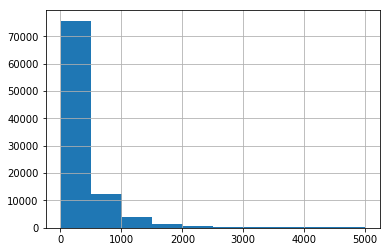

In [10]:
comment_len.hist()

In [11]:
label_cols = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']
raw_train_df['none'] = 1 - raw_train_df[label_cols].max(axis=1)

DataFrameSummary(raw_train_df).summary()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,none
count,95851,NaN,95851,95851,95851,95851,95851,95851,95851
mean,4.99436e+11,NaN,0.0963683,0.0100677,0.0533015,0.00318202,0.0497126,0.00849235,0.897862
std,2.89014e+11,NaN,0.295097,0.0998321,0.224635,0.0563199,0.217352,0.0917623,0.302831
min,2.22566e+07,NaN,0,0,0,0,0,0,0
25%,2.47344e+11,NaN,0,0,0,0,0,0,1
50%,5.0013e+11,NaN,0,0,0,0,0,0,1
75%,7.50109e+11,NaN,0,0,0,0,0,0,1
max,9.99988e+11,NaN,1,1,1,1,1,1,1
counts,95851,95851,95851,95851,95851,95851,95851,95851,95851
uniques,95851,95851,2,2,2,2,2,2,2


In [12]:
DataFrameSummary(test_df).summary()

,id,comment_text
count,153164,153164
unique,153164,153164
top,09b56e282e874eac,"Well as expected, two administrators, RRick and Gadfium, staff engineers in Silicon Valley have started using their deleting power on a newbie. Because they have to make sure African Americans are constantly denegrated and under attack, they will maintain their unbelievable attention to this stupid page, which only race oriented people would use ask their definition guide!"
freq,1,1
counts,153164,153164
uniques,153164,153164
missing,0,0
missing_perc,0%,0%
types,unique,unique


In [13]:
len(raw_train_df), len(test_df)

(95851, 153164)

Lets try this clean function from https://www.kaggle.com/jagangupta/stop-the-s-toxic-comments-eda

In [14]:
#https://drive.google.com/file/d/0B1yuv8YaUVlZZ1RzMFJmc1ZsQmM/view
# Aphost lookup dict
APPO = {
"aren't" : "are not",
"can't" : "cannot",
"couldn't" : "could not",
"didn't" : "did not",
"doesn't" : "does not",
"don't" : "do not",
"hadn't" : "had not",
"hasn't" : "has not",
"haven't" : "have not",
"he'd" : "he would",
"he'll" : "he will",
"he's" : "he is",
"i'd" : "I would",
"i'd" : "I had",
"i'll" : "I will",
"i'm" : "I am",
"isn't" : "is not",
"it's" : "it is",
"it'll":"it will",
"i've" : "I have",
"let's" : "let us",
"mightn't" : "might not",
"mustn't" : "must not",
"shan't" : "shall not",
"she'd" : "she would",
"she'll" : "she will",
"she's" : "she is",
"shouldn't" : "should not",
"that's" : "that is",
"there's" : "there is",
"they'd" : "they would",
"they'll" : "they will",
"they're" : "they are",
"they've" : "they have",
"we'd" : "we would",
"we're" : "we are",
"weren't" : "were not",
"we've" : "we have",
"what'll" : "what will",
"what're" : "what are",
"what's" : "what is",
"what've" : "what have",
"where's" : "where is",
"who'd" : "who would",
"who'll" : "who will",
"who're" : "who are",
"who's" : "who is",
"who've" : "who have",
"won't" : "will not",
"wouldn't" : "would not",
"you'd" : "you would",
"you'll" : "you will",
"you're" : "you are",
"you've" : "you have",
"'re": " are",
"wasn't": "was not",
"we'll":" will",
"didn't": "did not",
"tryin'":"trying"
}

In [15]:
import nltk
nltk.download('stopwords')
nltk.download('wordnet')

from nltk.corpus import stopwords
from nltk.tokenize import TweetTokenizer
from nltk.stem.wordnet import WordNetLemmatizer

eng_stopwords = set(stopwords.words("english"))
lem = WordNetLemmatizer()
tweet_tokenizer=TweetTokenizer()

def clean(comment):
    """
    This function receives comments and returns clean word-list
    """
    #Convert to lower case , so that Hi and hi are the same
    comment=comment.lower()
    #remove \n
    comment=re.sub("\\n","",comment)
    # remove leaky elements like ip,user
    comment=re.sub("\d{1,3}.\d{1,3}.\d{1,3}.\d{1,3}","",comment)
    #removing usernames
    comment=re.sub("\[\[.*\]","",comment)
    
    #Split the sentences into words
    words=tweet_tokenizer.tokenize(comment)
    
    # (')aphostophe  replacement (ie)   you're --> you are  
    # ( basic dictionary lookup : master dictionary present in a hidden block of code)
    words=[APPO[word] if word in APPO else word for word in words]
    words=[lem.lemmatize(word, "v") for word in words]
    words = [w for w in words if not w in eng_stopwords]
    
    clean_sent=" ".join(words)
    # remove any non alphanum,digit character
    #clean_sent=re.sub("\W+"," ",clean_sent)
    #clean_sent=re.sub("  "," ",clean_sent)
    return(clean_sent)

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/wgilliam/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /home/wgilliam/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [16]:
raw_train_df['clean_comment_text'] = raw_train_df.comment_text.apply(lambda x: clean(x))
test_df['clean_comment_text'] = test_df.comment_text.apply(lambda x: clean(x))

## Build Dataset and ModelData classes

In [17]:
class TextMultiLabelDataset(torchtext.data.Dataset):
    def __init__(self, df, tt_text_field, tt_label_field, txt_col, lbl_cols, **kwargs):
        # torchtext Field objects
        fields = [('text', tt_text_field)]
        for l in lbl_cols: fields.append((l, tt_label_field))
            
        is_test = False if lbl_cols[0] in df.columns else True
        n_labels = len(lbl_cols)
        
        examples = []
        for idx, row in df.iterrows():
            if not is_test:
                lbls = [ row[l] for l in lbl_cols ]
            else:
                lbls = [0.0] * n_labels
                
            txt = str(row[txt_col])
            examples.append(data.Example.fromlist([txt]+lbls, fields))
                            
        super().__init__(examples, fields, **kwargs)

    @staticmethod
    def sort_key(example): 
        return len(example.text)
    
    @classmethod
    def splits(cls, text_field, label_field, train_df, txt_col, lbl_cols, val_df=None, test_df=None, **kwargs):
        # build train, val, and test data
        train_data, val_data, test_data = (None, None, None)
        
        if train_df is not None: 
            train_data = cls(train_df.copy(), text_field, label_field, txt_col, lbl_cols, **kwargs)
        if val_df is not None: 
            val_data = cls(val_df.copy(), text_field, label_field, txt_col, lbl_cols, **kwargs)
        if test_df is not None: 
            test_data = cls(test_df.copy(), text_field, label_field, txt_col, lbl_cols, **kwargs)

        return tuple(d for d in (train_data, val_data, test_data) if d is not None)

In [18]:
class TextMultiLabelDataLoader():
    def __init__(self, src, x_fld, y_flds, y_dtype='torch.cuda.FloatTensor'):
        self.src, self.x_fld, self.y_flds = src, x_fld, y_flds
        self.y_dtype = y_dtype

    def __len__(self): return len(self.src)#-1

    def __iter__(self):
        it = iter(self.src)
        for i in range(len(self)):
            b = next(it)
            
            if (len(self.y_flds) > 1):
                targ = [ getattr(b, y) for y in self.y_flds ] 
                targ = torch.stack(targ, dim=1).type(self.y_dtype)
            else: 
                targ = getattr(b, self.y_flds[0])
                targ = targ.type(self.y_dtype)

            yield getattr(b, self.x_fld), targ

class TextMultiLabelData(ModelData):

    @classmethod
    def from_splits(cls, path, splits, bs, text_name='text', label_names=['label'], 
                    target_dtype='torch.cuda.FloatTensor'):
        
        text_fld = splits[0].fields[text_name]
        
        label_flds = []
        if (len(label_names) == 1): 
            label_fld = splits[0].fields[label_names[0]]
            label_flds.append(label_fld)
            if (label_fld.use_vocab): 
                label_fld.build_vocab(splits[0])
                target_dtype = 'torch.cuda.LongTensor'
        else:
            for n in label_names:
                label_fld = splits[0].fields[n]
                label_flds.append(label_fld)

        iters = torchtext.data.BucketIterator.splits(splits, batch_size=bs)
        trn_iter,val_iter,test_iter = iters[0],iters[1],None
        test_dl = None
        if len(iters) == 3:
            test_iter = iters[2]
            test_dl = TextMultiLabelDataLoader(test_iter, text_name, label_names, target_dtype)
        trn_dl = TextMultiLabelDataLoader(trn_iter, text_name, label_names, target_dtype)
        val_dl = TextMultiLabelDataLoader(val_iter, text_name, label_names, target_dtype)

        obj = cls.from_dls(path, trn_dl, val_dl, test_dl)
        obj.bs = bs
        obj.pad_idx = text_fld.vocab.stoi[text_fld.pad_token]
        obj.nt = len(text_fld.vocab)

        # if multiple labels, assume the # of classes = the # of labels 
        if (len(label_names) > 1):
            c = len(label_names)
        # if label has a vocab, assume the vocab represents the # of classes
        elif (hasattr(label_flds[0], 'vocab')): 
            c = len(label_flds[0].vocab)
        else:
            c = 1
            
        obj.c = c

        return obj

## Define our tokenizer and model

In [19]:
# def tokenizer(text): # create a tokenizer function
# #     return text.split()
#     return [tok.text for tok in spacy_en.tokenizer(text)]

Jeremy's tokenizer from his kernel here: https://www.kaggle.com/jhoward/nb-svm-strong-linear-baseline-eda-0-052-lb

In [46]:
import re, string
re_tok = re.compile(f'([{string.punctuation}“”¨«»®´·º½¾¿¡§£₤‘’])')
def tokenizer(s): return re_tok.sub(r' \1 ', s).split()

In [47]:
bsz = 8 #16 #32 #64

max_tokens = 20000 # max number of words based on frequency
max_len = None #100      # max length of each comment to look at

n_hidden = 256
n_fac = 64

In [48]:
class LstmClassifier(nn.Module):
    def __init__(self, vocab_size, n_fac, bsz, 
                 fc_szs=[], fc_drops=[], n_lstm_hidden=256, n_lstm_layers=1, out_sz=1,
                 lstm_drop=0.5, is_multi=False, y_range=None, use_bn=False):
        
        super().__init__()
        
        self.vocab_size, self.out_sz = vocab_size, out_sz
        self.n_lstm_layers, self.n_lstm_hidden = n_lstm_layers, n_lstm_hidden
        
        self.is_multi = is_multi
        self.y_range = y_range
        self.use_bn = use_bn
        
        self.e = nn.Embedding(vocab_size, n_fac)
        self.e.weight.data.uniform_(-0.1, 0.1)
        
        self.rnn = nn.LSTM(n_fac, n_lstm_hidden, n_lstm_layers, dropout=lstm_drop)
        
        fc_szs = [n_lstm_hidden] + fc_szs
        
        self.linears, self.linear_drops, self.linear_bns = [], [], []
        if (len(fc_szs) > 1):
            self.linears = nn.ModuleList(
                [ nn.Linear(fc_szs[idx], sz) for idx, sz in enumerate(fc_szs[1:]) ]
            )
            
            self.linear_bns = nn.ModuleList(
                [ nn.BatchNorm1d(sz) for sz in fc_szs[1:] ]
            )
            
            for l in self.linears: kaiming_normal(l.weight.data)
                
        if (len(fc_drops) > 0):
            self.linear_drops = nn.ModuleList([ nn.Dropout(d) for d in fc_drops ])
                
        self.outp = nn.Linear(fc_szs[-1], out_sz)
        kaiming_normal(self.outp.weight.data)
            
        self.h = self.init_hidden(bsz)
        
    def forward(self, words):
        bsz = words[0].size(0)
        if (self.h[0].size(1) != bsz): self.h = self.init_hidden(bsz)
            
        x, h = self.rnn(self.e(words), self.h)
        self.h = repackage_var(h)
        
        x = x[-1]
        
        for l, d, b in zip(self.linears, self.linear_drops, self.linear_bns):
            x = F.relu(l(x))
            if (self.use_bn): x = b(x)
            x = d(x)
        
        x = self.outp(x)

        if (self.is_multi):
            return F.sigmoid(x)
        
        if (not self.is_multi and self.out_sz > 1):
            return F.log_softmax(x)
        
        if (self.y_range):
            x = F.sigmoid(x)
            x = x * (self.y_range[1] - self.y_range[0])
            x = x + self.y_range[0]
            
        return x
    
    def init_hidden(self, bsz):
        return(V(torch.zeros(self.n_lstm_layers, bsz, self.n_lstm_hidden)), 
               V(torch.zeros(self.n_lstm_layers, bsz, self.n_lstm_hidden)))


## 1.  Multi-Label Classification

Predict class probabilities where multiple classes can be true

In [72]:
txt_col = 'clean_comment_text'

val_idxs = get_cv_idxs(len(raw_train_df), val_pct=0.1)

train_df =  raw_train_df.drop(val_idxs)
val_df = raw_train_df.copy().iloc[val_idxs]

len(train_df), len(val_df), len(test_df)

(86266, 9585, 153164)

Ensure target fields are the correct datatype

In [73]:
train_df[label_cols + ['none']] = train_df[label_cols + ['none']].astype(np.float32)
val_df[label_cols + ['none']] = val_df[label_cols + ['none']].astype(np.float32)

train_df.dtypes

id                    int64  
comment_text          object 
toxic                 float32
severe_toxic          float32
obscene               float32
threat                float32
insult                float32
identity_hate         float32
none                  float32
clean_comment_text    object 
dtype: object

Since our label is essentially a OHE vector, set `use_vocab=False` for the label's torchtext field

In [74]:
tt_TEXT = data.Field(sequential=True, tokenize=tokenizer, fix_length=max_len)
tt_LABEL = data.Field(sequential=False, use_vocab=False) # use_vocab=False if labels are numerical

In [75]:
splits = TextMultiLabelDataset.splits(tt_TEXT, tt_LABEL, train_df, 
                                      'comment_text', label_cols + ['none'], val_df, test_df)

# splits = TextMultiLabelDataset.splits(tt_TEXT, tt_LABEL, train_df, 
#                                       txt_col, label_cols, val_df, test_df)

In [76]:
# ------ multi-label problem ------
t = splits[0].examples[0]
t.toxic, t.insult, ' '.join(t.text)

(1.0,
 0.0,
 "Nonsense ? kiss off , geek . what I said is true . I ' ll have your account terminated .")

In [77]:
tt_TEXT.build_vocab(splits[0], max_size=max_tokens)

In [78]:
md = TextMultiLabelData.from_splits(PATH, splits, bsz, text_name='text', label_names=label_cols + ['none'])
# md = TextMultiLabelData.from_splits(PATH, splits, bsz, text_name='text', label_names=label_cols)

len(md.trn_dl), md.nt, md.c

(10784, 20002, 7)

Grab a batch and make sure it looks as expected (e.g., size and datatypes)

NOTE: After playing with a batch like this, reset your iterator (`md.val_dl.it.close()`).  When I went back to training after looking at a batch, though the predictions would be different for each label, they would be identical for each row.

In [79]:
x,y = next(iter(md.val_dl))

In [80]:
y.size(), y[:5,:]

(torch.Size([8, 7]), Variable containing:
     0     0     0     0     0     0     1
     1     1     1     0     0     0     0
     0     0     0     0     0     0     1
     0     0     0     0     0     0     1
     0     0     0     0     0     0     1
 [torch.cuda.FloatTensor of size 5x7 (GPU 0)])

In [81]:
md.val_dl.it.close()

Playground for seeing what a torchtext field gives us

In [82]:
print(tt_TEXT.vocab.stoi[tt_TEXT.pad_token])
print(tt_TEXT.vocab.itos[:10])

1
['<unk>', '<pad>', '.', ',', 'the', '"', 'to', 'I', 'of', "'"]


In [83]:
print('most common words: ')
tt_TEXT.vocab.freqs.most_common(10)

most common words: 


[('.', 369968),
 (',', 256529),
 ('the', 242333),
 ('"', 210215),
 ('to', 157588),
 ('I', 121070),
 ('of', 119718),
 ("'", 118690),
 ('and', 114839),
 ('a', 110598)]

In [84]:
print('least common words: ')
tt_TEXT.vocab.freqs.most_common()[-10:]

least common words: 


[('Bovineboy', 1),
 ('aggio', 1),
 ('SvWp', 1),
 ('alums', 1),
 ('pantsed', 1),
 ('Heonsi', 1),
 ('R41', 1),
 ('trotting', 1),
 ('plskthxbai', 1),
 ('wahabi', 1)]

### Train

In [85]:
m = LstmClassifier(md.nt, n_fac, bsz, [512, 256], [0.4, 0.2],
                   n_hidden, n_lstm_layers=1, out_sz=md.c, is_multi=True, use_bn=True).cuda()

lo = LayerOptimizer(optim.Adam, m, 1e-3, 1e-4)

In [86]:
fit(m, md, 1, lo.opt, F.binary_cross_entropy) 
# use F.binary_cross_entropy for multi-label problems

HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

epoch:   0, train_loss: 0.101189, val_loss: 0.107058              



In [87]:
# 4 cycles of len 1, 2, 4, 8

on_end = lambda sched, cycle: save_model(m, f'{PATH}/models/multi-label-cyc_{cycle}-of-4')
cb = [CosAnneal(lo, len(md.trn_dl), cycle_mult=2, on_cycle_end=on_end)]

fit(m, md, 2**4-1, lo.opt, F.binary_cross_entropy, callbacks=cb)

HBox(children=(IntProgress(value=0, description='Epoch', max=15), HTML(value='')))

epoch:   0, train_loss: 0.086670, val_loss: 0.101966              
epoch:   1, train_loss: 0.115624, val_loss: 0.105787              
epoch:   2, train_loss: 0.063796, val_loss: 0.099387              
epoch:   3, train_loss: 0.096943, val_loss: 0.120711              
epoch:   4, train_loss: 0.088000, val_loss: 0.097374              
epoch:   5, train_loss: 0.092271, val_loss: 0.089704              
epoch:   6, train_loss: 0.068992, val_loss: 0.092155              
epoch:   7, train_loss: 0.109500, val_loss: 0.092864              
epoch:   8, train_loss: 0.078277, val_loss: 0.103546              
epoch:   9, train_loss: 0.072766, val_loss: 0.094332              
epoch:  10, train_loss: 0.096662, val_loss: 0.094484              
epoch:  11, train_loss: 0.087408, val_loss: 0.099717              
epoch:  12, train_loss: 0.093081, val_loss: 0.093246              
epoch:  13, train_loss: 0.071157, val_loss: 0.106066              
epoch:  14, train_loss: 0.070634, val_loss: 0.093239          

In [88]:
# 1 cycle of len 10

on_end = lambda sched, cycle: save_model(m, f'{PATH}/models/multi-label-2-cyc_{cycle}-of-1')
cb = [CosAnneal(lo, len(md.trn_dl) * 10, on_cycle_end=on_end)]

fit(m, md, 10, lo.opt, F.binary_cross_entropy, callbacks=cb)

HBox(children=(IntProgress(value=0, description='Epoch', max=10), HTML(value='')))

epoch:   0, train_loss: 0.116827, val_loss: 0.098823              
epoch:   1, train_loss: 0.083464, val_loss: 0.097865              
epoch:   2, train_loss: 0.086959, val_loss: 0.095516              
epoch:   3, train_loss: 0.079783, val_loss: 0.098271              
epoch:   4, train_loss: 0.104110, val_loss: 0.093550              
epoch:   5, train_loss: 0.081411, val_loss: 0.092314              
epoch:   6, train_loss: 0.067334, val_loss: 0.093089              
epoch:   7, train_loss: 0.081514, val_loss: 0.095191              
epoch:   8, train_loss: 0.090165, val_loss: 0.105924              
epoch:   9, train_loss: 0.072762, val_loss: 0.090905              



Load best model and make predictions

In [66]:
load_model(m, f'{PATH}/models/multi-label-2-cyc_0-of-1')

In [67]:
preds = predict(m, md.test_dl)
len(preds), len(test_df), len(train_df), len(val_df)

(153164, 153164, 86266, 9585)

In [68]:
label_cols

['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']

In [69]:
subm_df = pd.DataFrame(data=preds, columns=label_cols) # -- if "none" included
# subm_df = pd.DataFrame(data=preds[:,:6], columns=label_cols) # -- if "none" included

subm_df.insert(0, 'id', test_df.id)
subm_df.tail(20)

,id,toxic,severe_toxic,obscene,threat,insult,identity_hate
153144,fff7159b3ee95618,0.649353,0.049358,0.365194,0.023031,0.340106,0.056535
153145,fff718ffe5f05559,0.610632,0.041627,0.322034,0.020729,0.306081,0.050376
153146,fff7fc22a0cdccd3,0.585741,0.037411,0.296549,0.019412,0.285878,0.046867
153147,fff83b80284d8440,0.573432,0.035507,0.284552,0.018799,0.276321,0.045241
153148,fff8ef316d0c6990,0.571875,0.035274,0.283062,0.018724,0.275132,0.045040
153149,fff8f521a7dbcd47,0.571877,0.035275,0.283064,0.018724,0.275134,0.045041
153150,fff8f64043129fa2,0.571843,0.035270,0.283032,0.018722,0.275108,0.045036
153151,fff9d70fe0722906,0.010160,0.000140,0.001615,0.000220,0.001886,0.000415
153152,fff9fa508f400ee6,0.770773,0.086369,0.530578,0.031454,0.464476,0.080382
153153,fffa3fae1890b40a,0.586869,0.037591,0.297668,0.019469,0.286768,0.047019


In [70]:
len(preds), len(test_df)

(153164, 153164)

In [71]:
subm_df.to_csv(f'{PATH}/multi-label_sub-removed-none-label.csv', index=None)

## 2. Multi-Classification Problem

Predict a class probabilities where a single class is true

In [ ]:
target_col = 'toxic'

In [ ]:
val_idxs = get_cv_idxs(len(raw_train_df), val_pct=0.20)

train_df =  raw_train_df.drop(val_idxs)
val_df = raw_train_df.copy().iloc[val_idxs]

len(train_df), len(val_df), len(test_df)

Ensure our targets are strings (torchtext will automatically build categorical embedding)

In [ ]:
train_df[label_cols + ['none']] = train_df[label_cols + ['none']].astype(str)
val_df[label_cols + ['none']] = val_df[label_cols + ['none']].astype(str)

train_df.dtypes

Since we are using the target's unique string values to define our categories, set `use_vocab=True`.  For this example, it will return 3 values for each of the following 3 classes ('<unk>', '0', '1')

In [ ]:
tt_TEXT = data.Field(sequential=True, tokenize=tokenizer, fix_length=max_len)
tt_LABEL = data.Field(sequential=False, use_vocab=True) # use_vocab=False if labels are numerical

splits = TextMultiLabelDataset.splits(tt_TEXT, tt_LABEL, train_df, 'comment_text', [target_col], val_df, None)

In [ ]:
tt_TEXT.build_vocab(splits[0], max_size=max_tokens)

md = TextMultiLabelData.from_splits(PATH, splits, bsz, text_name='text', label_names=[target_col])

len(md.trn_dl), md.nt, md.c

In [ ]:
# ------ multi-class problem ------
t = splits[0].examples[0]
t.toxic, ' '.join(t.text)

In [ ]:
x,y = next(iter(md.val_dl))
y.size(), y[:5]

In [ ]:
m = LstmClassifier(md.nt, n_fac, bsz, [512, 256], [0.4, 0.2],
                   n_hidden, n_lstm_layers=1, out_sz=md.c, use_bn=True).cuda()

lo = LayerOptimizer(optim.Adam, m, 1e-3, 1e-4)

In [ ]:
fit(m, md, 2, lo.opt, F.nll_loss, metrics=[accuracy])

In [ ]:
on_end = lambda sched, cycle: save_model(m, f'{PATH}models/cyc_{cycle}')
cb = [CosAnneal(lo, len(md.trn_dl), cycle_mult=2)]#, on_cycle_end=on_end)]

fit(m, md, 2**4-1, lo.opt, F.nll_loss, callbacks=cb, metrics=[accuracy])

In [ ]:
on_end = lambda sched, cycle: save_model(m, f'{PATH}models/cyc_{cycle}')
cb = [CosAnneal(lo, len(md.trn_dl)*10)]#, on_cycle_end=on_end)]

fit(m, md, 10, lo.opt, F.nll_loss, callbacks=cb, metrics=[accuracy])

## 3. Regression Problem

Predict a single continuous value

In [ ]:
target_col = 'toxic'

In [ ]:
val_idxs = get_cv_idxs(len(raw_train_df), val_pct=0.20)

train_df =  raw_train_df.drop(val_idxs)
val_df = raw_train_df.copy().iloc[val_idxs]

len(train_df), len(val_df), len(test_df)

Ensure correct datatypes for our target 

In [ ]:
train_df[label_cols + ['none']] = train_df[label_cols + ['none']].astype(np.float32)
val_df[label_cols + ['none']] = val_df[label_cols + ['none']].astype(np.float32)

train_df.dtypes

Set `use_vocab=False` since we are predicting a single number (a regression problem)

In [ ]:
tt_TEXT = data.Field(sequential=True, tokenize=tokenizer, fix_length=max_len)
tt_LABEL = data.Field(sequential=False, use_vocab=False) # use_vocab=False if labels are numerical

splits = TextMultiLabelDataset.splits(tt_TEXT, tt_LABEL, train_df, 'comment_text', [target_col], val_df, None)

In [ ]:
tt_TEXT.build_vocab(splits[0], max_size=max_tokens)

md = TextMultiLabelData.from_splits(PATH, splits, bsz, text_name='text', label_names=[target_col])

len(md.trn_dl), md.nt, md.c

In [ ]:
# ------ multi-class problem ------
t = splits[0].examples[0]
t.toxic, ' '.join(t.text)

In [ ]:
x,y = next(iter(md.val_dl))
y.size(), y[:5]

In [ ]:
m = LstmClassifier(md.nt, n_fac, bsz, [512, 256], [0.4, 0.2],
                   n_hidden, n_lstm_layers=1, out_sz=md.c, y_range=(0,1), use_bn=True).cuda()

lo = LayerOptimizer(optim.Adam, m, 1e-3, 1e-4)

In [ ]:
fit(m, md, 1, lo.opt, F.mse_loss, metrics=[accuracy])

In [ ]:
on_end = lambda sched, cycle: save_model(m, f'{PATH}models/cyc_{cycle}')
cb = [CosAnneal(lo, len(md.trn_dl), cycle_mult=2)]#, on_cycle_end=on_end)]

fit(m, md, 2**4-1, lo.opt, F.mse_loss, callbacks=cb, metrics=[accuracy])

In [ ]:
on_end = lambda sched, cycle: save_model(m, f'{PATH}models/cyc_{cycle}')
cb = [CosAnneal(lo, len(md.trn_dl)*10, cycle_mult=2)]#, on_cycle_end=on_end)]

fit(m, md, 10, lo.opt, F.mse_loss, callbacks=cb, metrics=[accuracy])

## Helpful debugging code

In [ ]:
train_iter = data.BucketIterator(splits[0], batch_size=32, device=0, sort_key=lambda ex: len(ex.text))
vars(next(iter(train_iter)))

In [ ]:
batch_iter = iter(md.val_dl)

In [ ]:
b = next(batch_iter) # x, y
p = m(V(b[0]))       # predictions

print(b[0].size(), b[1].size(), p.size())

In [ ]:
# first 25 predictions and actuals
p[:25], b[1][:25]

In [ ]:
# the text of the 7th example
# b[0] = training data
# b[0][:,6] = give me all values of column 6; remember with bptt the shape = 

' '.join(tt_TEXT.vocab.itos[i] for i in b[0][:,6].data)

In [ ]:
# IMPORTANT - close iterator when done!!!
md.val_dl.it.close()